In [1]:
%pip install ultralytics transformers torch torchvision opencv-python pillow numpy


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 9.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/802.4 kB ? eta -:--:--
   --------------------------------------- 802.4/802.4 kB 11.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/44.5 MB ? eta -:--:--
   --- ------------------------------------ 3.9/44.5 MB 19.5 MB/s eta 0:00:03
   ------ --------------------------------- 7.1/44.5 MB 18.9 MB/s eta 0:00:02
   --------- ------------------------------ 10.7/44.5 MB 17.7 MB/s eta 0:00:02
   -------------- ------------------------- 16.5/44.5 MB 20.0 MB/s eta 0:00:02
   ------------------ --------------------- 20.7/44.5 MB 20.1 MB/s eta 0:00:02
   ------------------------ --------------- 26.7/44.5 MB 21.4 MB/s eta 0:00:01
   ----------------------------- ---------- 32.8/44.5 MB 22.4 MB/s eta 0:00:01
   --


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
from ultralytics import YOLO
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import torch
import cv2
from PIL import Image
import numpy as np




In [9]:

device = "cuda" if torch.cuda.is_available() else "cpu"

# 2️⃣ Load YOLO (local .pt file)
yolo_model = YOLO(r"C:\Users\Gowri Shankar\Downloads\Kambaa\best.pt")  # Windows-safe
print("YOLO model loaded ✅")
print("Classes:", yolo_model.names)


YOLO model loaded ✅
Classes: {0: 'crazing', 1: 'inclusion', 2: 'patches', 3: 'pitted_surface', 4: 'rolled-in_scale', 5: 'scratches'}


In [10]:
# 3️⃣ Load SegFormer

processor = SegformerImageProcessor.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512"
)

seg_model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512"
).to(device)
seg_model.eval()

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

C:\Users\Gowri Shankar\AppData\Roaming\Python\Python312\site-packages\transformers\utils\deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [22]:
# 4️⃣ Read image
# ------------------------------
image_path = "crack.jpg"  # Windows-safe path or raw string
image = cv2.imread(image_path)
assert image is not None, "❌ Image not found"


In [23]:
# 5️⃣ Run YOLO detection
# ------------------------------
results = yolo_model(image, conf=0.3)
detections = results[0]

# ------------------------------
# 6️⃣ Class mapping (update if your model differs)
# ------------------------------
CLASS_MAP = {0: 'crazing', 1: 'inclusion', 2: 'patches', 3: 'pitted_surface', 4: 'rolled-in_scale', 5: 'scratches'}


0: 352x640 1 patches, 208.4ms
Speed: 7.8ms preprocess, 208.4ms inference, 2.6ms postprocess per image at shape (1, 3, 352, 640)


In [24]:
# 7️⃣ Severity calculation (Windows-safe, avoids double counting)
# ------------------------------
def calculate_severity(image, detections):
    H, W = image.shape[:2]
    global_mask = np.zeros((H, W), dtype=np.uint8)
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    for box in detections.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        # Clamp coordinates to image size
        x1 = max(0, min(W - 1, x1))
        x2 = max(0, min(W, x2))
        y1 = max(0, min(H - 1, y1))
        y2 = max(0, min(H, y2))

        # Skip invalid boxes
        if x2 <= x1 or y2 <= y1:
            continue

        crop = pil_image.crop((x1, y1, x2, y2))
        inputs = processor(images=crop, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = seg_model(**inputs)

        mask = torch.argmax(outputs.logits, dim=1).squeeze().cpu().numpy()
        mask = cv2.resize(mask, (x2 - x1, y2 - y1), interpolation=cv2.INTER_NEAREST)
        global_mask[y1:y2, x1:x2] |= (mask > 0).astype(np.uint8)

    affected_pixels = np.sum(global_mask)
    total_pixels = H * W
    return round((affected_pixels / total_pixels) * 100, 2)

In [25]:
# 8️⃣ Extract detected issues
# ------------------------------
issues = set()
efflorescence = False

for box in detections.boxes:
    cls = int(box.cls)
    issue = CLASS_MAP.get(cls, "Unknown")
    issues.add(issue)
    if issue == "Efflorescence":
        efflorescence = True

In [26]:
# 9️⃣ Severity bucket
# ------------------------------
def severity_bucket(severity):
    if severity <= 5:
        return "0-5%"
    elif severity <= 10:
        return "6-10%"
    elif severity <= 25:
        return "11-25%"
    else:
        return ">25%"

In [ ]:
# 🔟 Rule-based recommendation

def recommend_products(bucket, efflorescence):
    if bucket == "0-5%":
        return {"putty": ["WP Putty"], "primer": ["Damp Protect Interior"], "topcoat": ["Premium Interior Paint"]}
    if bucket == "6-10%":
        return {"putty": ["Crystal Seal"], "primer": ["Damp Protect Interior", "Damp Lock"], "topcoat": ["Premium Interior Paint"]}
    if bucket == "11-25%":
        return {"putty": ["Crystal Seal"], "primer": ["Damp Lock"], "topcoat": ["Premium Interior Paint"]}
    if bucket == ">25%" and not efflorescence:
        return {"putty": ["Crystal Seal"], "primer": ["Super 2K on Plaster"], "topcoat": ["Premium Interior Paint"]}
    return {"putty": ["Crystal Seal"], "primer": ["Super 2K on Brick Wall"], "topcoat": ["Premium Interior Paint"]}


In [28]:
# 1️⃣1️⃣ Paint calculation (example)
# ------------------------------
def calculate_paint(area_sqft, coverage=120, coats=2):
    return round((area_sqft / coverage) * coats, 2)

In [29]:
# 1️⃣2️⃣ Final execution
# ------------------------------
severity = calculate_severity(image, detections)
bucket = severity_bucket(severity)
recommendation = recommend_products(bucket, efflorescence)

final_output = {
    "issues_detected": list(issues),
    "severity_percent": severity,
    "severity_bucket": bucket,
    "efflorescence": efflorescence,
    "recommended_system": recommendation,
    "paint_required_litres": calculate_paint(120)  # example wall area
}

print(final_output)



{'issues_detected': ['patches'], 'severity_percent': np.float64(5.68), 'severity_bucket': '6-10%', 'efflorescence': False, 'recommended_system': {'putty': ['Crystal Seal'], 'primer': ['Damp Protect Interior', 'Damp Lock'], 'topcoat': ['Premium Interior Paint']}, 'paint_required_litres': 2.0}


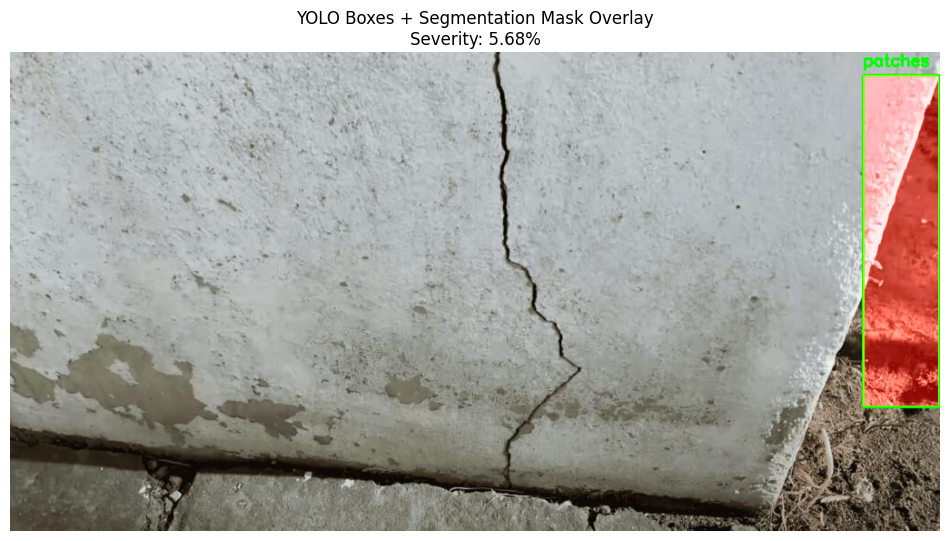

In [30]:
import matplotlib.pyplot as plt

# Make a copy of the image to draw on
vis_image = image.copy()

# ------------------------------
# 1️⃣ Draw YOLO boxes
# ------------------------------
for box in detections.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    cls = int(box.cls)
    label = CLASS_MAP.get(cls, "Unknown")
    
    # Draw rectangle
    cv2.rectangle(vis_image, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
    
    # Put label
    cv2.putText(vis_image, label, (x1, max(y1-10,0)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

# ------------------------------
# 2️⃣ Generate Segmentation mask
# ------------------------------
H, W = image.shape[:2]
global_mask = np.zeros((H, W), dtype=np.uint8)
pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

for box in detections.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    # Clamp coordinates
    x1 = max(0, min(W-1, x1))
    x2 = max(0, min(W, x2))
    y1 = max(0, min(H-1, y1))
    y2 = max(0, min(H, y2))
    if x2 <= x1 or y2 <= y1:
        continue
    
    crop = pil_image.crop((x1, y1, x2, y2))
    inputs = processor(images=crop, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = seg_model(**inputs)
    mask = torch.argmax(outputs.logits, dim=1).squeeze().cpu().numpy()
    mask = cv2.resize(mask, (x2 - x1, y2 - y1), interpolation=cv2.INTER_NEAREST)
    global_mask[y1:y2, x1:x2] |= (mask > 0).astype(np.uint8)

# ------------------------------
# 3️⃣ Overlay segmentation mask
# ------------------------------
# Create a color mask (red)
color_mask = np.zeros_like(vis_image)
color_mask[:,:,2] = global_mask * 255  # Red channel

# Blend with original image
alpha = 0.5
overlayed_image = cv2.addWeighted(vis_image, 1.0, color_mask, alpha, 0)

# ------------------------------
# 4️⃣ Show result
# ------------------------------
plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"YOLO Boxes + Segmentation Mask Overlay\nSeverity: {severity}%")
plt.show()


MODEL CLASSES: {0: 'crazing', 1: 'inclusion', 2: 'patches', 3: 'pitted_surface', 4: 'rolled-in_scale', 5: 'scratches'}
✅ Model loaded

0: 640x640 3 patchess, 2 pitted_surfaces, 320.3ms
Speed: 16.7ms preprocess, 320.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

===== FINAL OUTPUT =====
Defects Detected: ['pitted_surface', 'patches']
Severity %: 41.04
Severity Category: Critical
Primer: Surface Reconstruction Required
Topcoat: Interior Paint
Paint Required (L): 2.0


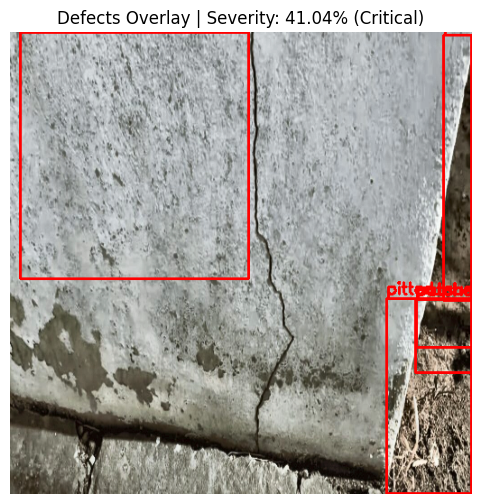

Masks: None


In [5]:
import cv2
import numpy as np
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt

# -----------------------------
# CONFIG
# -----------------------------
MODEL_PATH = "best.pt"
IMAGE_PATH = "crack.jpg"
COVERAGE_SQFT_PER_L = 120
COATS = 2

# -----------------------------
# LOAD MODEL
# -----------------------------
model = YOLO(MODEL_PATH)

print("MODEL CLASSES:", model.names)
DEFECT_CLASSES = model.names
print("✅ Model loaded")

# -----------------------------
# READ & PREPROCESS IMAGE
# -----------------------------
image = cv2.imread(IMAGE_PATH)
assert image is not None, "❌ Image not found"

orig = image.copy()
image = cv2.resize(image, (512, 512))

# Illumination correction
lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(2.0, (8,8))
l = clahe.apply(l)
image = cv2.merge((l,a,b))
image = cv2.cvtColor(image, cv2.COLOR_LAB2BGR)

# -----------------------------
# INFERENCE
# -----------------------------
results = model(image)[0]

# -----------------------------
# WALL AREA ESTIMATION
# -----------------------------
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, wall_mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
wall_pixels = np.sum(wall_mask > 0)

# -----------------------------
# DEFECT AREA CALCULATION
# -----------------------------
defect_pixels = 0
detected_defects = set()
overlay = image.copy()

for box in results.boxes:
    cls_id = int(box.cls)
    defect_name = model.names[cls_id]
    detected_defects.add(defect_name)

    x1, y1, x2, y2 = map(int, box.xyxy[0])
    defect_pixels += (x2 - x1) * (y2 - y1)

    # Draw bounding box
    cv2.rectangle(overlay, (x1, y1), (x2, y2), (0, 0, 255), 2)
    cv2.putText(
        overlay, defect_name, (x1, y1 - 5),
        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2
    )


# -----------------------------
# SEVERITY
# -----------------------------
severity_percent = round((defect_pixels / wall_pixels) * 100, 2)

# -----------------------------
# SEVERITY BUCKET
# -----------------------------
if severity_percent <= 5:
    severity_category = "Minor"
elif severity_percent <= 10:
    severity_category = "Moderate"
elif severity_percent <= 25:
    severity_category = "Severe"
else:
    severity_category = "Critical"

# -----------------------------
# RECOMMENDATION ENGINE
# -----------------------------
if "efflorescence" in detected_defects:
    primer = "Alkali Resistant Primer"
elif severity_category == "Minor":
    primer = "Interior Primer"
elif severity_category == "Moderate":
    primer = "Damp Protect Primer"
elif severity_category == "Severe":
    primer = "Damp Lock Primer"
else:
    primer = "Surface Reconstruction Required"

topcoat = "Interior Paint"

# -----------------------------
# PAINT CALCULATION
# -----------------------------
WALL_AREA_SQFT = 120  # example
paint_required = round((WALL_AREA_SQFT / COVERAGE_SQFT_PER_L) * COATS, 2)

# -----------------------------
# OUTPUT
# -----------------------------
print("\n===== FINAL OUTPUT =====")
print("Defects Detected:", list(detected_defects))
print("Severity %:", severity_percent)
print("Severity Category:", severity_category)
print("Primer:", primer)
print("Topcoat:", topcoat)
print("Paint Required (L):", paint_required)

# -----------------------------
# VISUALIZATION
# -----------------------------
plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title(f"Defects Overlay | Severity: {severity_percent}% ({severity_category})")
plt.axis("off")
plt.show()
print("Masks:", results.masks)

